<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [34]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [35]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [36]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [37]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



In [38]:
y_s1

,pdq
date,
2015-01-04,23.337079
2015-01-11,25.687861
2015-01-18,26.547170
2015-01-25,27.267016
2015-02-01,28.213018
...,...
2021-10-31,24.603306
2021-11-07,24.494949
2021-11-14,24.160000




* Primero haremos gráficos para cada y_si, osea para cada tipo de dalito, haremos un gráfico de de la fecha "date" vs "pdq" en la amplitud total de la fecha de la que se tienen datos, esto para tener una visión global de nuestros datos.






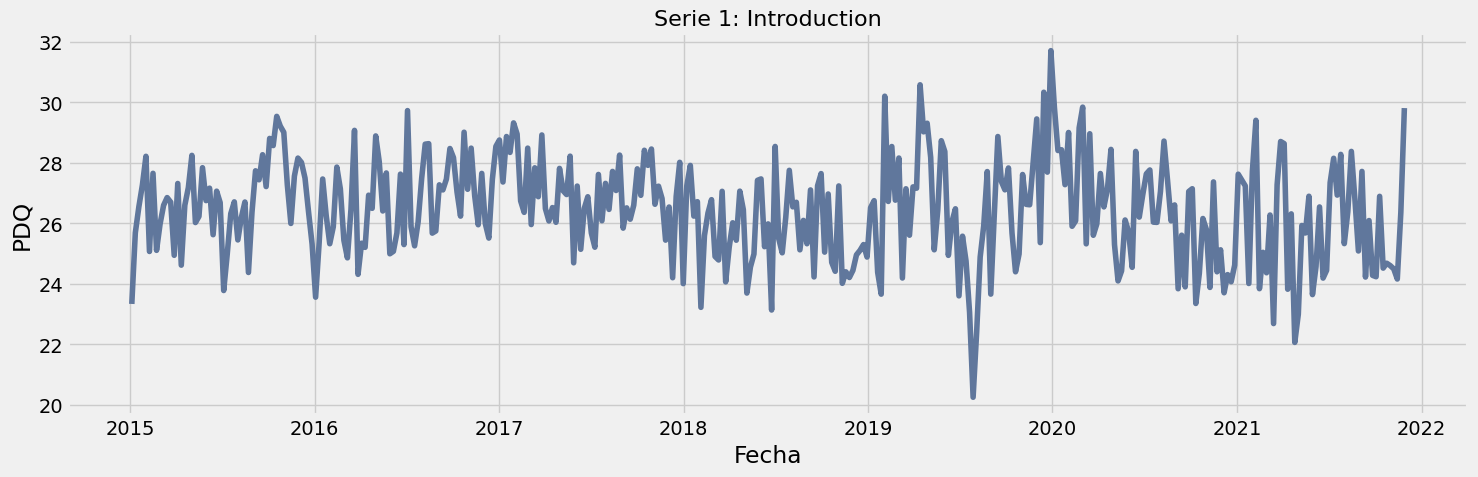

In [39]:

# y_s1
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_s1, x='date', y='pdq')
plt.title('Serie 1: Introduction', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


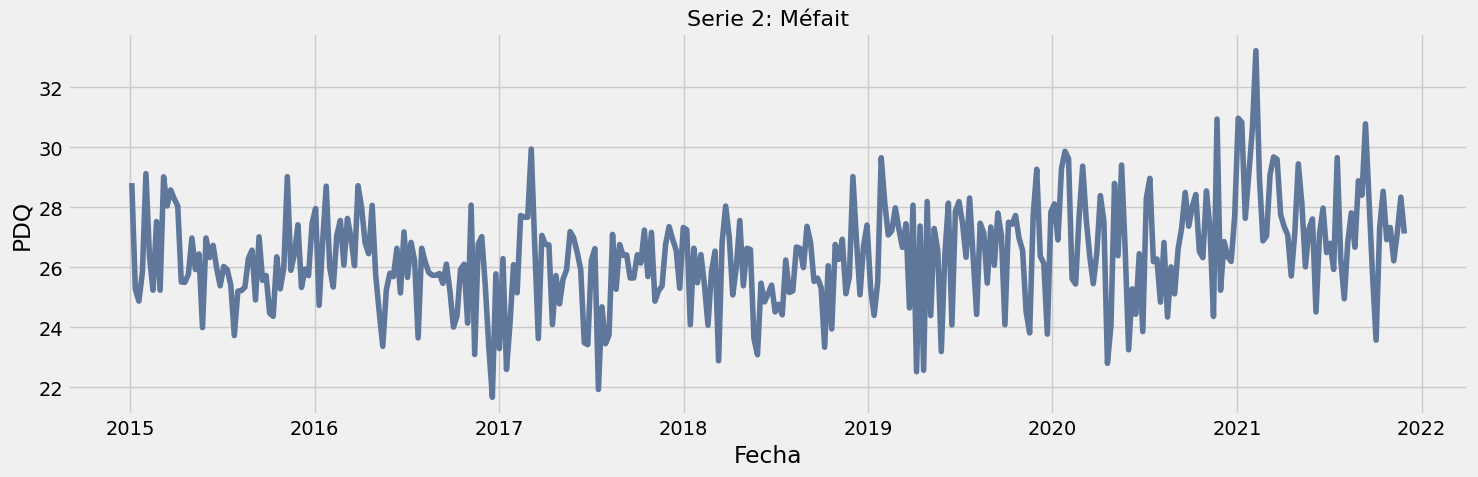

In [40]:
# y_s2
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_s2, x='date', y='pdq')
plt.title('Serie 2: Méfait', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

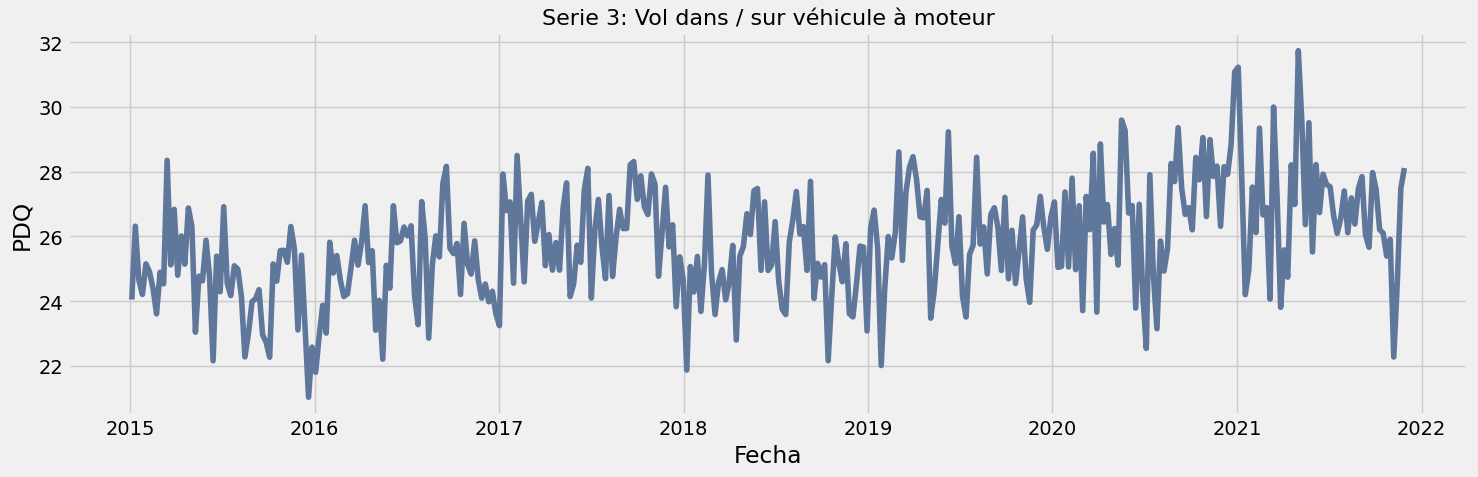

In [41]:
# y_s3
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_s3, x='date', y='pdq')
plt.title('Serie 3: Vol dans / sur véhicule à moteur', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

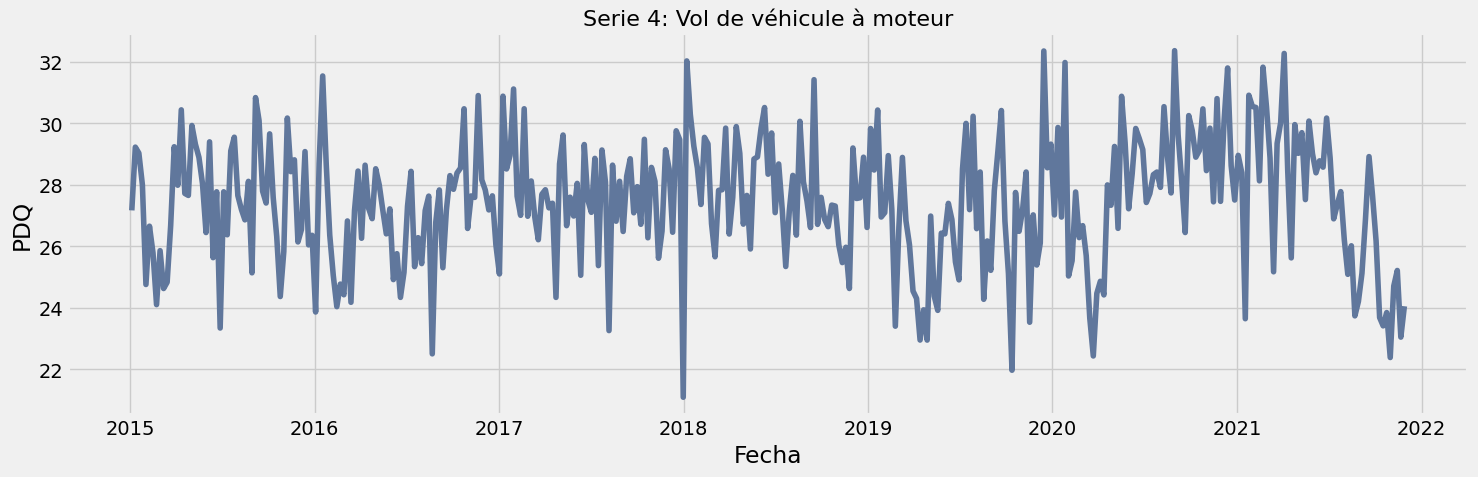

In [42]:
# y_s4
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_s4, x='date', y='pdq')
plt.title('Serie 4: Vol de véhicule à moteur', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

* Ahora haremos gráficos de año a año para el tipo de delito de y_s1

In [43]:
# copiamos y_s1 para no que no cambie el original
y_s1copy = y_s1.copy()

In [44]:
# Creaamos columnas de 'año' y 'semana'
y_s1copy['year'] = y_s1copy.index.year
y_s1copy['week'] = y_s1copy.index.isocalendar().week

In [45]:
# Convertir el año a 'category' para que seaborn lo trate como líneas separadas
y_s1copy['year'] = y_s1copy['year'].astype('category')

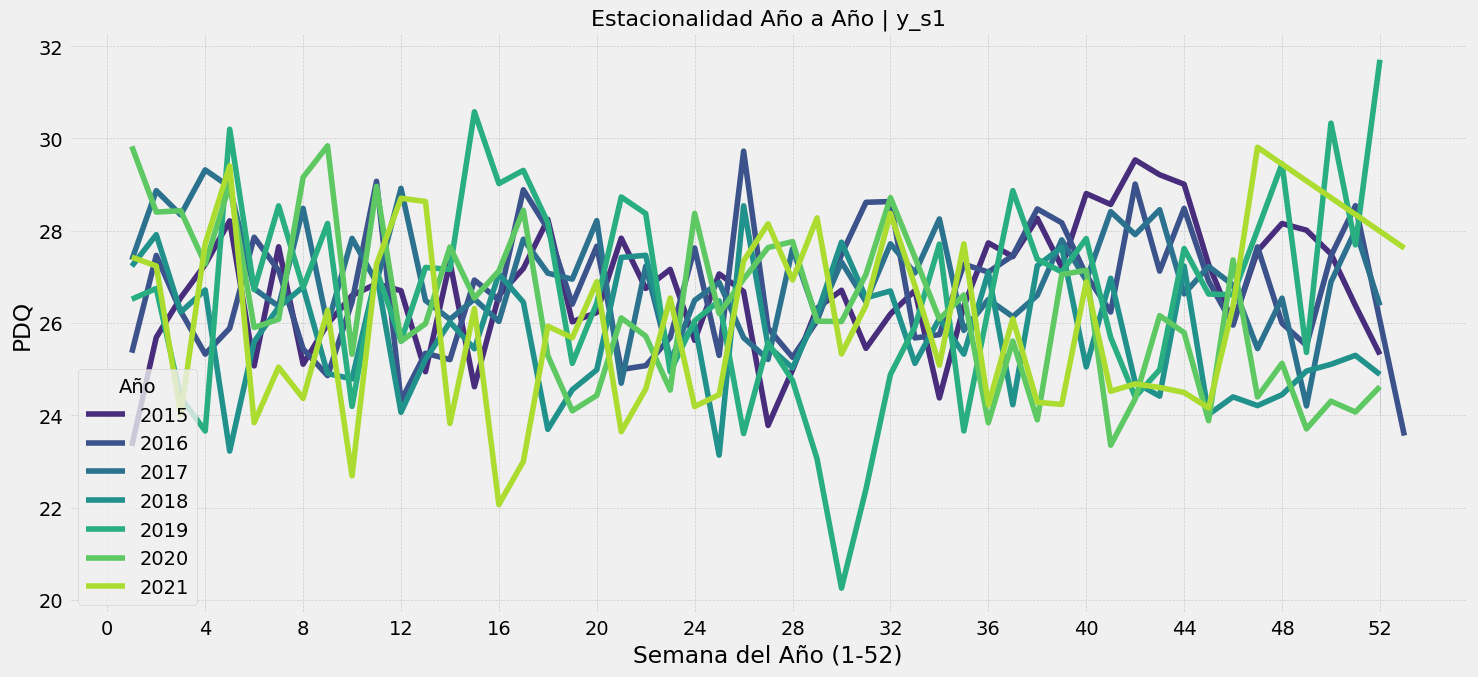

In [46]:
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=y_s1copy,
    x='week',
    y='pdq',
    hue='year',
    palette='viridis'
)

plt.title('Estacionalidad Año a Año | y_s1', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Semana del Año (1-52)')
plt.legend(title='Año')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(range(0, 53, 4)) # Muestra una marca cada 4 semanas

plt.tight_layout()
plt.show()

* Ahora haremos el mismo gráficos pero solo con 3 años continuados para el el gráfico sea más entendible visualmente

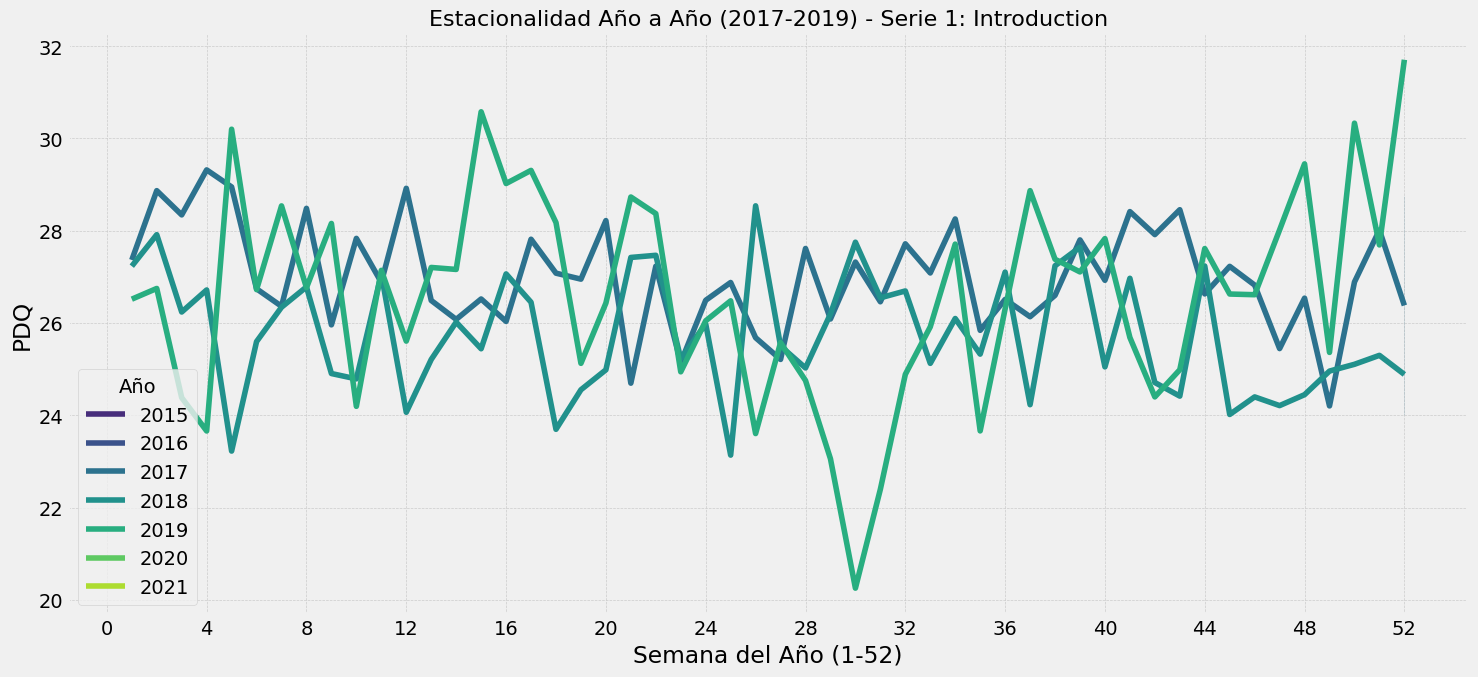

In [47]:
years_to_plot = [2017, 2018, 2019]

# Filtramos la copia para quedarnos con esos años
y_s1_3years = y_s1copy[y_s1copy['year'].isin(years_to_plot)]

plt.figure(figsize=(15, 7))
sns.lineplot(
    data=y_s1_3years,
    x='week',
    y='pdq',
    hue='year',
    palette='viridis'
)

plt.title('Estacionalidad Año a Año (2017-2019) - Serie 1: Introduction', fontsize=16)
plt.ylabel('PDQ')
plt.xlabel('Semana del Año (1-52)')
plt.legend(title='Año')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.xticks(range(0, 53, 4)) # Muestra una marca cada 4 semanas

plt.tight_layout()
plt.show()

Respecto al gráfico anterior, yo por lo menos al ojos no veo un patrón muy marcado viendo los 3 año, también notemos que la baja de delitos entre la semana 28 y 32 no es que hubieran habido, si no que la columna pdq parte desde 20.

In [48]:
# Usamos la variable y_s1copy que ya tiene las columnas 'year' y 'week'
check_data = y_s1copy[
    (y_s1copy['year'] == 2019) &
    (y_s1copy['week'] >= 28) &
    (y_s1copy['week'] <= 32)
]

print("Revisando los datos de y_s1 para 2019, semanas 28-32:")
print(check_data)

Revisando los datos de y_s1 para 2019, semanas 28-32:
                  pdq  year  week
date                             
2019-07-14  24.753521  2019    28
2019-07-21  23.057971  2019    29
2019-07-28  20.255319  2019    30
2019-08-04  22.398305  2019    31
2019-08-11  24.886364  2019    32




1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [49]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

* En coorcondacia con nuestro gráficos en la sección anterior, ya que estudiamos en profundidades y_s1, escogeremos este conjunto para realizar nuestro análisis.

Descomposición de la Serie y_s1 Introduction


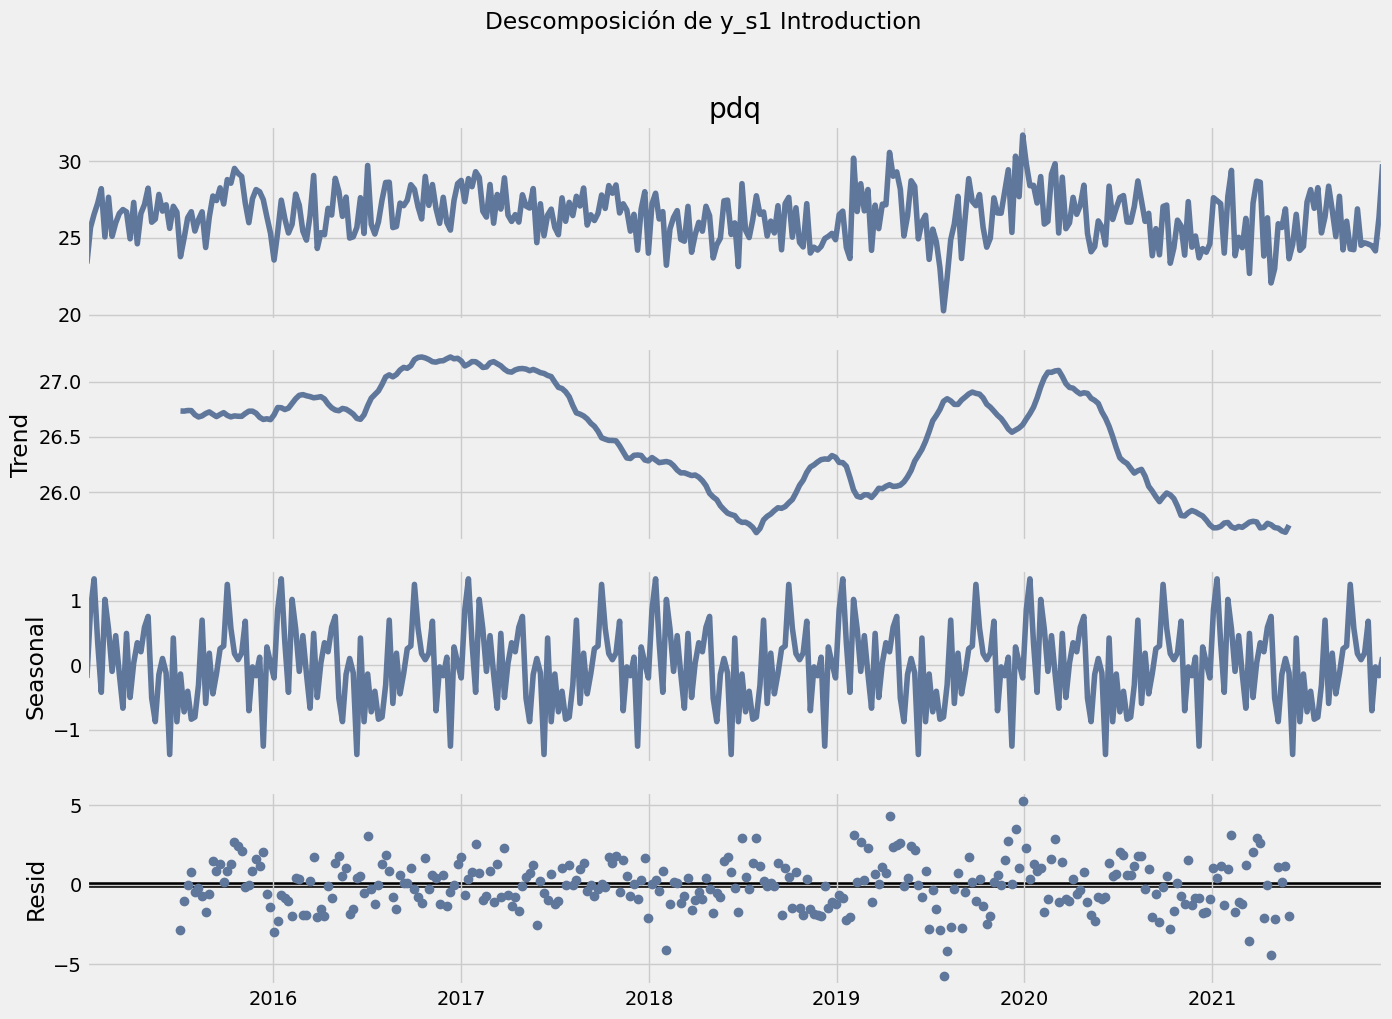

In [50]:
# analizamos estacionalidad e intentemos buscar patrones y tendencias

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y_s1copy['pdq'], model='additive', period=52)

print("Descomposición de la Serie y_s1 Introduction")
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Descomposición de y_s1 Introduction', y=1.02)
plt.tight_layout()
plt.show()

* En Trend no logro identificar un patron muy claro a largo plazo más que cuando hay bajas muy abruptas, luego también sube muy abruptamente.
* En seasonal si se logra identificar que hay como dos pics en cada año
* El residuo reconoce la bajo muy abrupta de crimenes en el 2019

Para el modelo con SARIMA y encontrar hipeparametros buenos nos ayudamos con IA, descubriendo dos métodos.


*   Box-Jenkins method: este es el más clásico pero requiere un análisis profundo de gráfico. Es bastante completo
*   Grid seearch: Este es más fuerza bruta por así decirle, osea más simple en primer lugar. Me quedare con este



In [51]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignorar warnings de convergencia
warnings.filterwarnings("ignore")

p = d = q = range(0, 2)
pdq_params = list(itertools.product(p, d, q))

# Usamos S=52 ya que nuestro datos
# son semanales y hay 52 semanas en un año
seasonal_pdq_params = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

params_grid = list(itertools.product(pdq_params, seasonal_pdq_params))

y = y_s1.copy()
all_metrics = []

print(f"Vamos a usar Grid Search de {len(params_grid)} modelos para y_s1")
print(f"Fecha de corte (Test): {target_date}")
#la fecha de corte venía definida ya en el bloque anteror de código del lab

# Iteramos sobre todas las 64 combinaciones
for param in params_grid:
    try:
        model = SarimaModels(params=param)
        metrics_df = model.metrics(y, target_date)

        if not metrics_df.empty:
            all_metrics.append(metrics_df)
    except Exception as e:
        continue

if not all_metrics:
    print("Error: No se pudieron ajustar los modelos.")
else:
    # Combinamos todos los resultados en un dataframe
    results_df = pd.concat(all_metrics).sort_values('mae').reset_index(drop=True)

    print("mejores modelos encontrandos por Grid Search")
    print(results_df.head())

    # tomamaos el mejor modelo
    best_model_config = results_df.iloc[0]
    best_model_name = best_model_config['model']

    model_params_str = best_model_name.replace('SARIMA_', '').split('X')
    best_order = eval(model_params_str[0])
    best_seasonal_order = eval(model_params_str[1])

    print(f"\n Mejor modelo")
    print(f"Modelo: {best_model_name}")
    print(f"Parámetros: Order={best_order}, Seasonal Order={best_seasonal_order}")
    print(f"MAE: {best_model_config['mae']:.4f}, RMSE: {best_model_config['rmse']:.4f}")

    best_sarima_model = SarimaModels(params=[best_order, best_seasonal_order])

Vamos a usar Grid Search de 64 modelos para y_s1
Fecha de corte (Test): 2021-01-01
mejores modelos encontrandos por Grid Search
      mae     mse    rmse    mape   maape  wmape   mmape   smape  \
0  1.7325  4.7111  2.1705  0.0646  0.0643  0.067  0.0622  0.0671   
1  1.7326  4.7115  2.1706  0.0646  0.0643  0.067  0.0622  0.0671   
2  1.7327  4.4857  2.1179  0.0681  0.0678  0.067  0.0655  0.0668   
3  1.7335  4.7229  2.1732  0.0646  0.0644  0.067  0.0623  0.0672   
4  1.7336  4.4704  2.1143  0.0681  0.0677  0.067  0.0655  0.0669   

                       model  
0  SARIMA_(1,1,1)X(0,0,1,52)  
1  SARIMA_(1,1,1)X(1,0,1,52)  
2  SARIMA_(0,0,0)X(1,0,1,52)  
3  SARIMA_(1,1,1)X(0,0,0,52)  
4  SARIMA_(0,0,1)X(1,0,1,52)  

 Mejor modelo
Modelo: SARIMA_(1,1,1)X(0,0,1,52)
Parámetros: Order=(1, 1, 1), Seasonal Order=(0, 0, 1, 52)
MAE: 1.7325, RMSE: 2.1705


Ahora analizaremos el modelo y veremos el efecto de los resudios vieno el Prob(Q) (Ljung-Box), que esperaríamosque fuera mayor a 0.5 pero que los residuos se hubieran comportado como ruido blanco.

Entrenando el modelo óptimo con datos hasta 2020-12-27 00:00:00...
                                     SARIMAX Results                                      
Dep. Variable:                                pdq   No. Observations:                  313
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 52)   Log Likelihood                -478.745
Date:                            Thu, 06 Nov 2025   AIC                            965.491
Time:                                    21:32:13   BIC                            979.703
Sample:                                01-04-2015   HQIC                           971.206
                                     - 12-27-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0505      0.079      0.636    

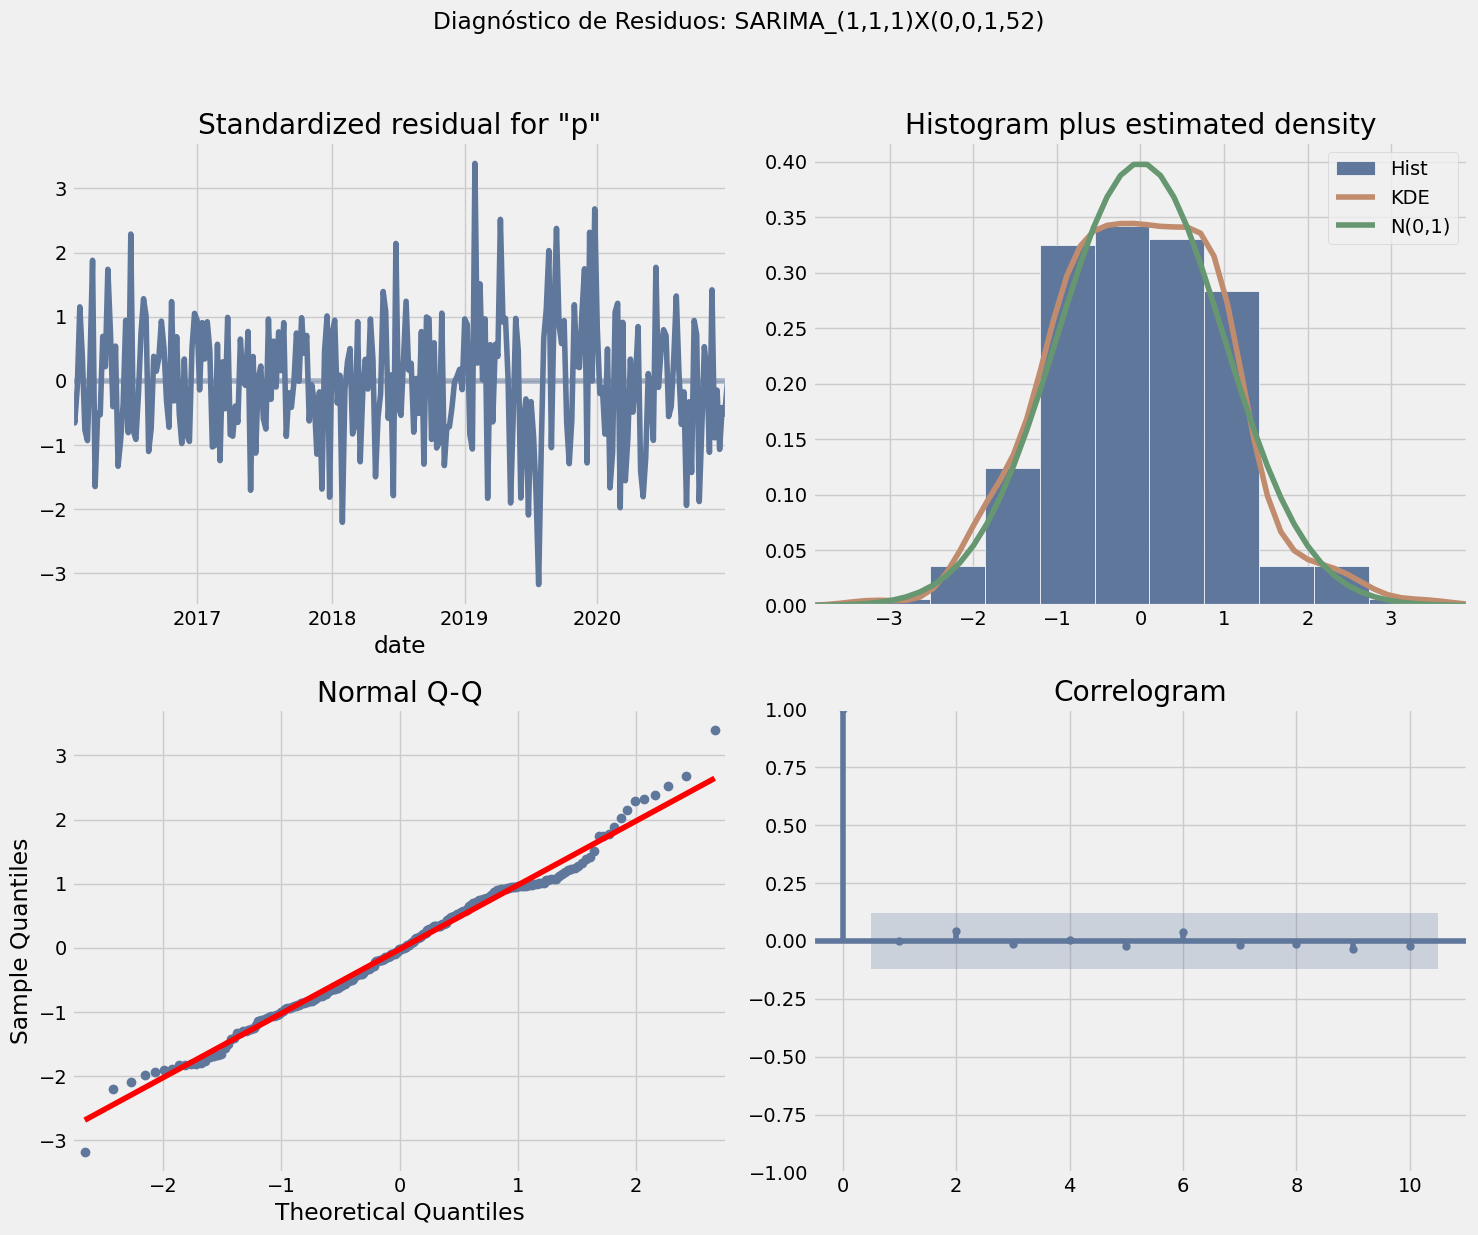

In [52]:
y_train, y_test = best_sarima_model.test_train_model(y_s1, target_date)

print(f"Entrenando el modelo óptimo con datos hasta {y_train.index.max()}...")


# Reentranamos para analizar los residuos
model_fit = SARIMAX(
    y_train['pdq'],         # Datos de entrenamiento
    order=best_order,       # (1, 1, 1)
    seasonal_order=best_seasonal_order, # (0, 0, 1, 52)
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=0)

# Vemos el resumen estadístico
#    Aquí es donde buscamos "Prob(Q)" (Ljung-Box). Queremos > 0.05
print(model_fit.summary())


# Graificamos los valores residuales
print("Gráficos de Diagnóstico de Residuos")
fig = model_fit.plot_diagnostics(figsize=(15, 12))
plt.suptitle(f'Diagnóstico de Residuos: {best_model_name}', y=1.03)
plt.tight_layout()
plt.show()

De esta forma al haber obtenido Prob(Q) = 1.00 y al confirmarse visualmente esto podemos decir que el modelo captura de buena forma la parte predecible de los datos




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [53]:
from prophet import Prophet

Haremos lo mismo realizando anteriormente pero adapta de Prophet

In [54]:
#Usaremos estos datos
mask_ds = y_s1.index < target_date
y_train = y_s1[mask_ds]
y_test = y_s1[~mask_ds]

In [55]:
#Los ajustamos a prophet
# Prophet requiere columnas 'ds' (fecha) y 'y' (valor)
y_train_prophet = y_train.reset_index().rename(columns={'date': 'ds', 'pdq': 'y'})
y_test_prophet = y_test.reset_index().rename(columns={'date': 'ds', 'pdq': 'y'})

In [56]:
#Definimos el modelo a entrenar
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

In [57]:
#Entrenamos
model_prophet.fit(y_train_prophet)

In [58]:
#Hacemos lasprediciciones
future_dates = model_prophet.make_future_dataframe(periods=len(y_test_prophet), freq='W')
forecast_prophet = model_prophet.predict(future_dates)

In [59]:
#Vemos nuestros resultados

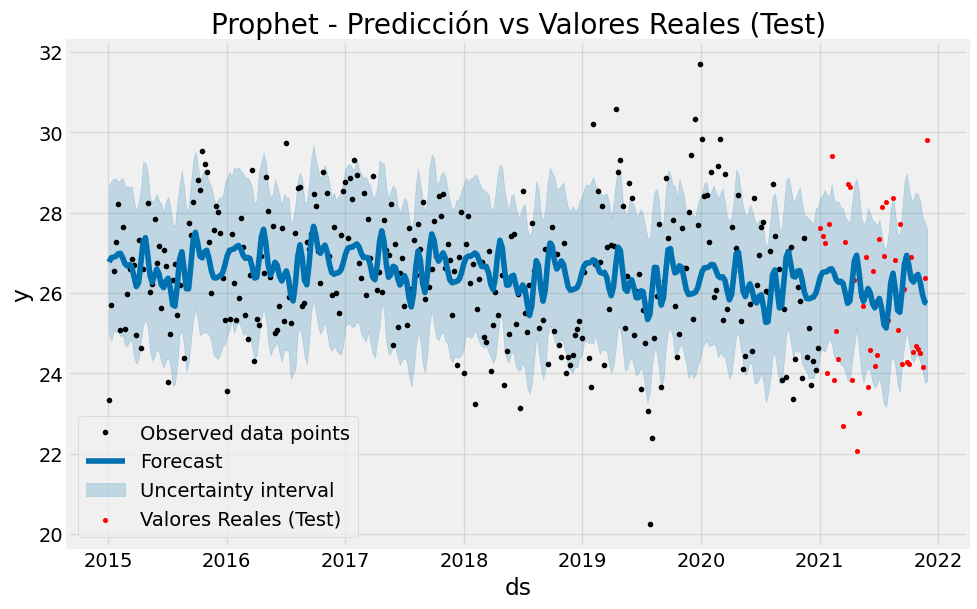

Mostrando gráfico de componentes de Prophet...


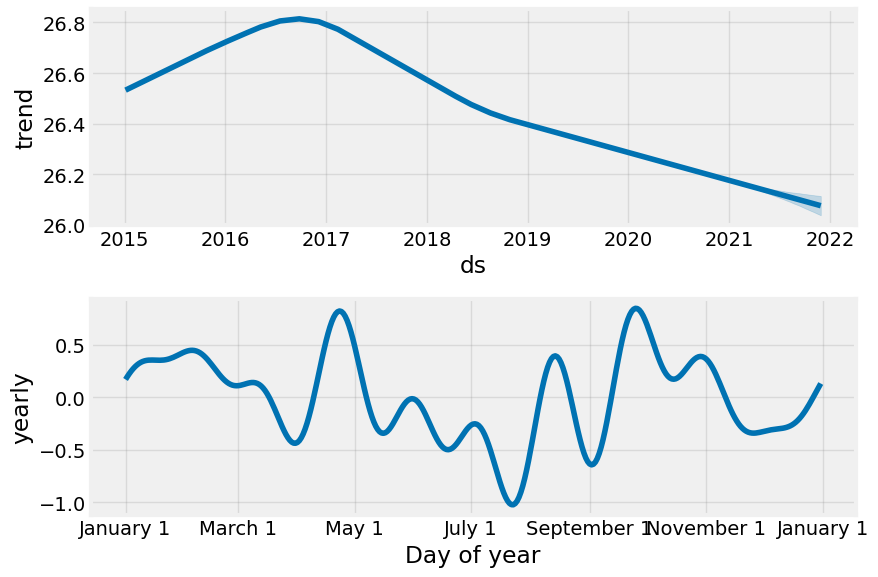

In [60]:
fig1 = model_prophet.plot(forecast_prophet)
# Añadimos los puntos reales del test set para comparar
plt.scatter(y_test_prophet['ds'], y_test_prophet['y'], color='red', s=10, label='Valores Reales (Test)')
plt.legend()
plt.title('Prophet - Predicción vs Valores Reales (Test)')
plt.show()

print("Mostrando gráfico de componentes de Prophet...")
fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()

Ahora evaluaremos el modelo y haremos la comparación:

In [61]:
# Unimos predicciones con valores reales del test set
df_test_prophet = pd.merge(
    y_test_prophet,
    forecast_prophet[['ds', 'yhat']],
    on='ds',
    how='left'
).rename(columns={'y': 'y'})

In [62]:
# vemos las métricas de Prophet
metrics_prophet = summary_metrics(df_test_prophet)
metrics_prophet['model'] = 'Prophet'

In [63]:
#recordamos las métricas del mejor modelo sarima encontrado anteriormente
metrics_sarima = results_df.iloc[0:1].copy()

In [64]:
# Juntamos las métricas de ambos modelos para comparar
comparison_df = pd.concat([metrics_sarima, metrics_prophet])

In [65]:
print(comparison_df[['model', 'mae', 'rmse', 'wmape']].to_markdown(index=False))

| model                     |    mae |   rmse |   wmape |
|:--------------------------|-------:|-------:|--------:|
| SARIMA_(1,1,1)X(0,0,1,52) | 1.7325 | 2.1705 |   0.067 |
| Prophet                   | 1.7079 | 2.0324 |   0.066 |


De esta forma en nuestro caso tenemmos que ambos modelos son buenos pero Prophet es un poco mejor pero por muy poco